In [84]:
import pandas as pd
import dateutil
import warnings
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

import plotly.offline as pyo 
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots

pd.set_option('display.max_colwidth', 1000)
warnings.filterwarnings('ignore')

from nltk import WordNetLemmatizer 
from nltk.downloader import download as nltkDownload
from nltk.corpus import stopwords as nltkStopwords
nltkDownload('vader_lexicon')
nltkDownload('wordnet')
nltkDownload('stopwords')

import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/praneeth/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/praneeth/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/praneeth/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [85]:
dataset_df = pd.read_csv('../data/chatgpt_daily_tweets.csv')
dataset_en_df = dataset_df[dataset_df['lang'] == 'en'].reset_index().drop(columns='index')
dataset_en_df

In [86]:
def clean_data(dataset_df: pd.DataFrame) -> pd.DataFrame:
    try:
        data = dataset_df.copy()
        data = data[data['lang'] == 'en']
        
        # Convert the 'date' column to datetime format and remove the timezone information
        data['tweet_created'] = data['tweet_created'].apply(lambda x: dateutil.parser.parse(x))
        data['tweet_created'] = pd.to_datetime(data['tweet_created']).dt.tz_localize(None)

        # data['tweet_extracted'] = data['tweet_extracted'].apply(lambda x: dateutil.parser.parse(x))
        # data['tweet_extracted'] = pd.to_datetime(data['tweet_extracted']).dt.tz_localize(None)

        # Text cleaning
        data['text'] = data['text'].str.lower()

        # Remove twitter handlers
        data['text'] = data['text'].apply(lambda x:re.sub('@[^\s]+','',x))

        # Remove hashtags
        data['text'] = data['text'].apply(lambda x:re.sub(r'\B#\S+','',x))

        # Remove URLS
        data['text'] = data['text'].apply(lambda x:re.sub(r"http\S+", "", x))

        # Remove all the special characters
        data['text'] = data['text'].apply(lambda x:' '.join(re.findall(r'\w+', x)))

        # Remove all single characters
        data['text'] = data['text'].apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))

        # Substituting multiple spaces with single space
        data['text'] = data['text'].apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))


        data = data.rename(columns={
            'text': 'original_tweet',
            'tweet_created': 'datetime'
        })

        data = data.reset_index().drop(columns='index')
        return data
    except ... as e:
        # Catch all errors
        print(f'Caught Error: {e}')


In [87]:
data = clean_data(dataset_df)
data.head()

In [88]:
def label_sentiment(x: float) -> int:
    if x < -0.05 : return 2
    if x > 0.05 : return 1
    return 0

def label_sentiment_text(x: float) -> str:
    if x < -0.05 : return 'Negative'
    if x > 0.05 : return 'Positive'
    return 'Neutral'

In [89]:
def perform_feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    # Sentiment intensity analyzer
    sia = SIA()
    data['sentiment'] = [sia.polarity_scores(x)['compound'] for x in data['original_tweet']]
    data['overall_sentiment'] = data['sentiment'].apply(label_sentiment)
    data['overall_sentiment_text'] = data['sentiment'].apply(label_sentiment_text)

    # Feature extraction from tweet text
    data['words'] = data['original_tweet'].apply(lambda x:re.findall(r'\w+', x ))
    
    data['words_count'] = data['words'].apply(len)
    data['sentence_length'] = data['original_tweet'].apply(len)
    data['hour'] = data['datetime'].apply(lambda x: x.hour)
    data['date'] = data['datetime'].apply(lambda x: x.date())
    data['month'] = data['datetime'].apply(lambda x: x.month)
    data['year'] = data['datetime'].apply(lambda x: x.year)

    wn = WordNetLemmatizer()
    stopwords = nltkStopwords.words('english')
    data['lemmetized_words'] = data['words'].apply(lambda words: [wn.lemmatize(word) for word in words if word not in stopwords])

    return data
    

In [90]:
data_with_features = perform_feature_engineering(data)
data_with_features.head()

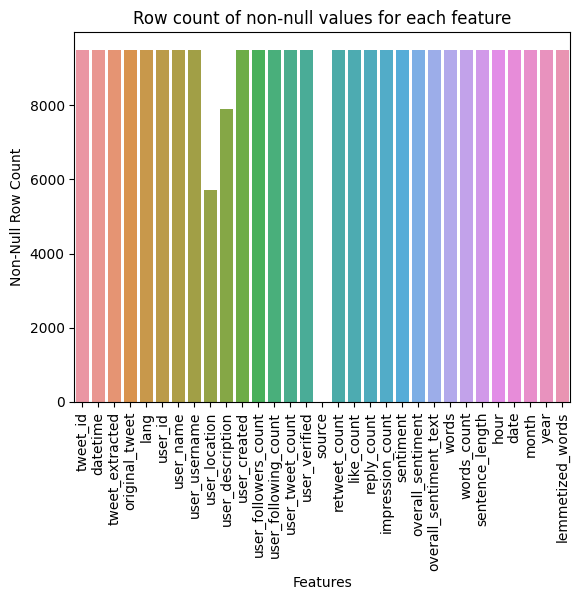

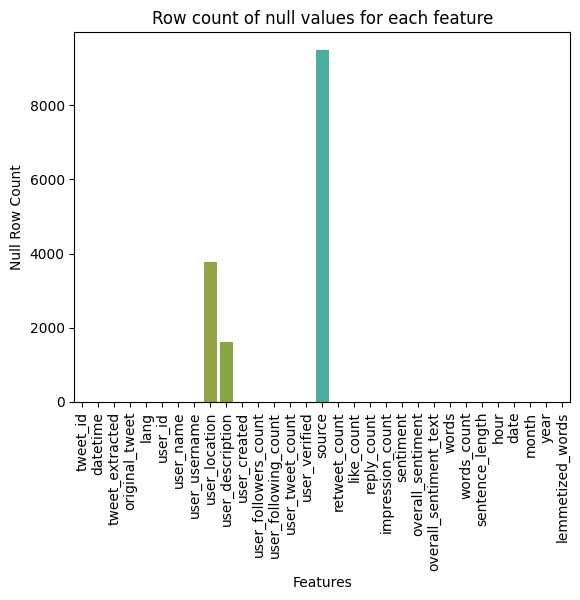

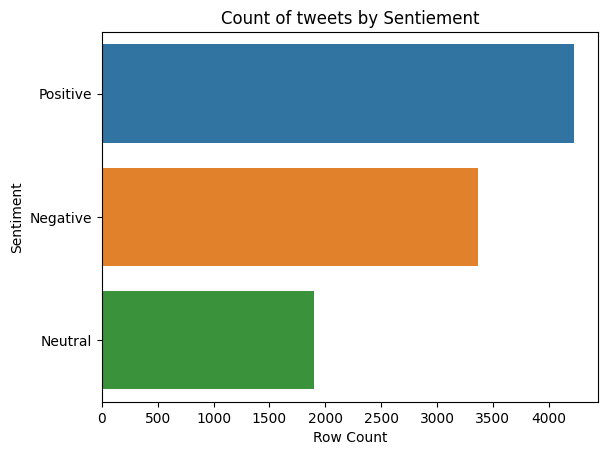

In [91]:
# Row counts
features = data.columns
row_counts = [data[feat].count() for feat in features]
barplot = sns.barplot(x=features, y=row_counts)
plt.setp(barplot.get_xticklabels(), rotation=90)
barplot.set(xlabel='Features', ylabel='Non-Null Row Count', title='Row count of non-null values for each feature')
plt.show(barplot)

hist1 = px.histogram(x=features, y=row_counts, title='Row count of non-null values for each feature'
                     , labels={'x': 'Features', 'y': 'Non-Null Row Count'}
                     )
hist1.show()

count_na = [data[feat].isna().sum() for feat in features]
barplot2 = sns.barplot(x=features, y=count_na)
plt.setp(barplot2.get_xticklabels(), rotation=90)
barplot2.set(xlabel='Features', ylabel='Null Row Count', title='Row count of null values for each feature')
plt.show(barplot2)

hist2 = px.histogram(x=features, y=count_na, title='Row count of null values for each feature'
                     , labels={'x': 'Features', 'y': 'Null Row Count'}
                     , color=features
                     )
hist2.show()

barplot3 = sns.barplot(y=data['overall_sentiment_text'].unique(), x=data['overall_sentiment_text'].value_counts())
barplot3.set(ylabel='Sentiment', xlabel='Row Count', title='Count of tweets by Sentiement')
plt.show(barplot3)

hist3 = px.histogram(data_frame=data, y='overall_sentiment_text'
                     , title='Count of tweets by Sentiement'
                     , labels={'overall_sentiment_text': 'Sentiment'}
                     , color='overall_sentiment_text')
hist3.show()

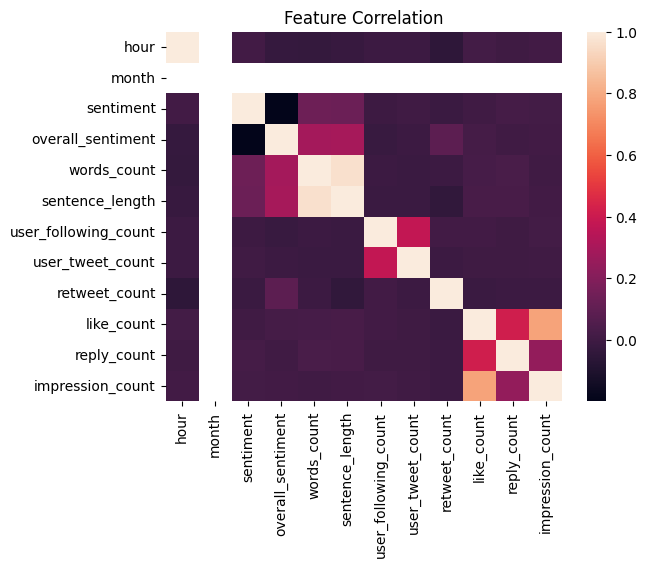

In [92]:
# Feature correlation
data_features_only = data[['hour', 'month', 'sentiment', 'overall_sentiment', 'words_count',
                           'sentence_length', 'user_following_count', 'user_tweet_count', 'retweet_count', 'like_count', 'reply_count', 'impression_count']]
correlation = data_features_only.corr()
heatmap = sns.heatmap(correlation)
heatmap.set(title = 'Feature Correlation')
plt.show(heatmap)

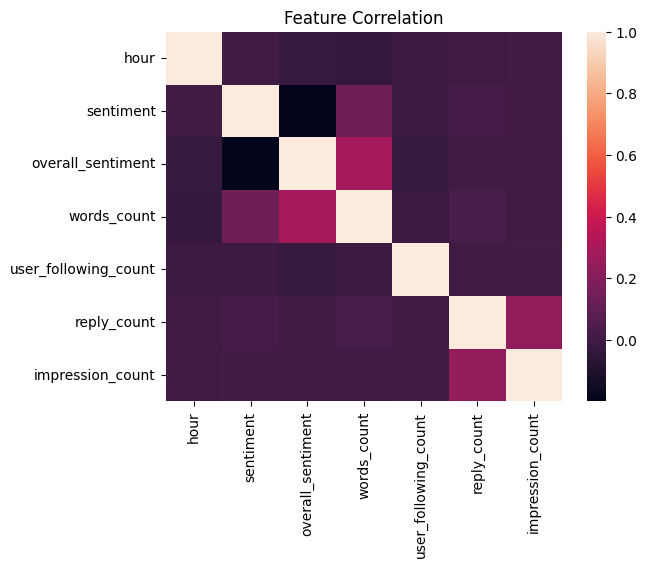

In [93]:
# Based on the above heat map, 
# 1. month is not adding any value.
# 2. word_count and sentence_length are highly correlated. So, dropping one of them
# 3. like_count and impression_count are also highly correlated. So, dropping one of them
data_features_only = data_features_only.drop(columns=['sentence_length', 'month', 'like_count', 'retweet_count', 'user_tweet_count'], 
                                             axis=1)
correlation = data_features_only.corr()
heatmap = sns.heatmap(correlation)
heatmap.set(title = 'Feature Correlation')
plt.show(heatmap)

In [94]:
df_preprocessed = data[['original_tweet', 'hour', 'sentiment', 'overall_sentiment', 'words_count',
                        'user_following_count', 'user_followers_count', 
                        'reply_count', 'impression_count']]
df_preprocessed.to_csv('../data/chatgpt_daily_tweets_eda.csv', index_label='index')